# PODs across readouts

In [25]:
import polars as pl
import pandas as pd
from scipy.stats import ttest_rel, pearsonr
import numpy as np


output_dir = "../../1_snakemake/outputs"

## Compare PODs across assays (CellProfiler for morph)

In [26]:
# Compile all PODs into one dataframe
feat_path = f"{output_dir}/cellprofiler/mad_featselect"
prof_path = f"{feat_path}/profiles/mad_featselect.parquet"


In [27]:

data = pl.read_parquet(prof_path)

cc = pl.read_parquet(f"{feat_path}/curves/ccpods.parquet").filter(pl.col("all.pass") == True).filter(pl.col('adv.incr') == 'false').select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_cc_POD"})
ldh = pl.read_parquet(f"{feat_path}/curves/ldhpods.parquet").filter(pl.col("all.pass") == True).filter(pl.col('adv.incr') == 'true').select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_ldh_POD"})
mtt = pl.read_parquet(f"{feat_path}/curves/mttpods.parquet").filter(pl.col("all.pass") == True).filter(pl.col('adv.incr') == 'false').select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_mtt_POD"})
morph = pl.read_parquet(f"{feat_path}/curves/pods.parquet").select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_morph_POD"})

data = data.join(cc, on="Metadata_Compound", how="left")
data = data.join(ldh, on="Metadata_Compound", how="left")
data = data.join(mtt, on="Metadata_Compound", how="left")
data = data.join(morph, on="Metadata_Compound", how="left")

all_pods = data.select([
    "Metadata_Compound",
    "Metadata_cc_POD",
    "Metadata_ldh_POD",
    "Metadata_mtt_POD",
    "Metadata_morph_POD",
]).unique()

In [28]:
all_pods_long = all_pods.drop_nulls().unpivot(
    index=["Metadata_Compound"],
    on=["Metadata_cc_POD", "Metadata_ldh_POD", "Metadata_mtt_POD", "Metadata_morph_POD"],
    variable_name="POD_Type",
    value_name="POD_Value"
).drop_nulls().to_pandas()

all_pods_long['POD_Type'] = pd.Categorical(
    all_pods_long['POD_Type'],
    categories=["Metadata_morph_POD", "Metadata_mtt_POD", "Metadata_cc_POD", "Metadata_ldh_POD"],
    ordered=True
)

In [29]:
all_pods_long['Metadata_Compound'].unique().shape

(131,)

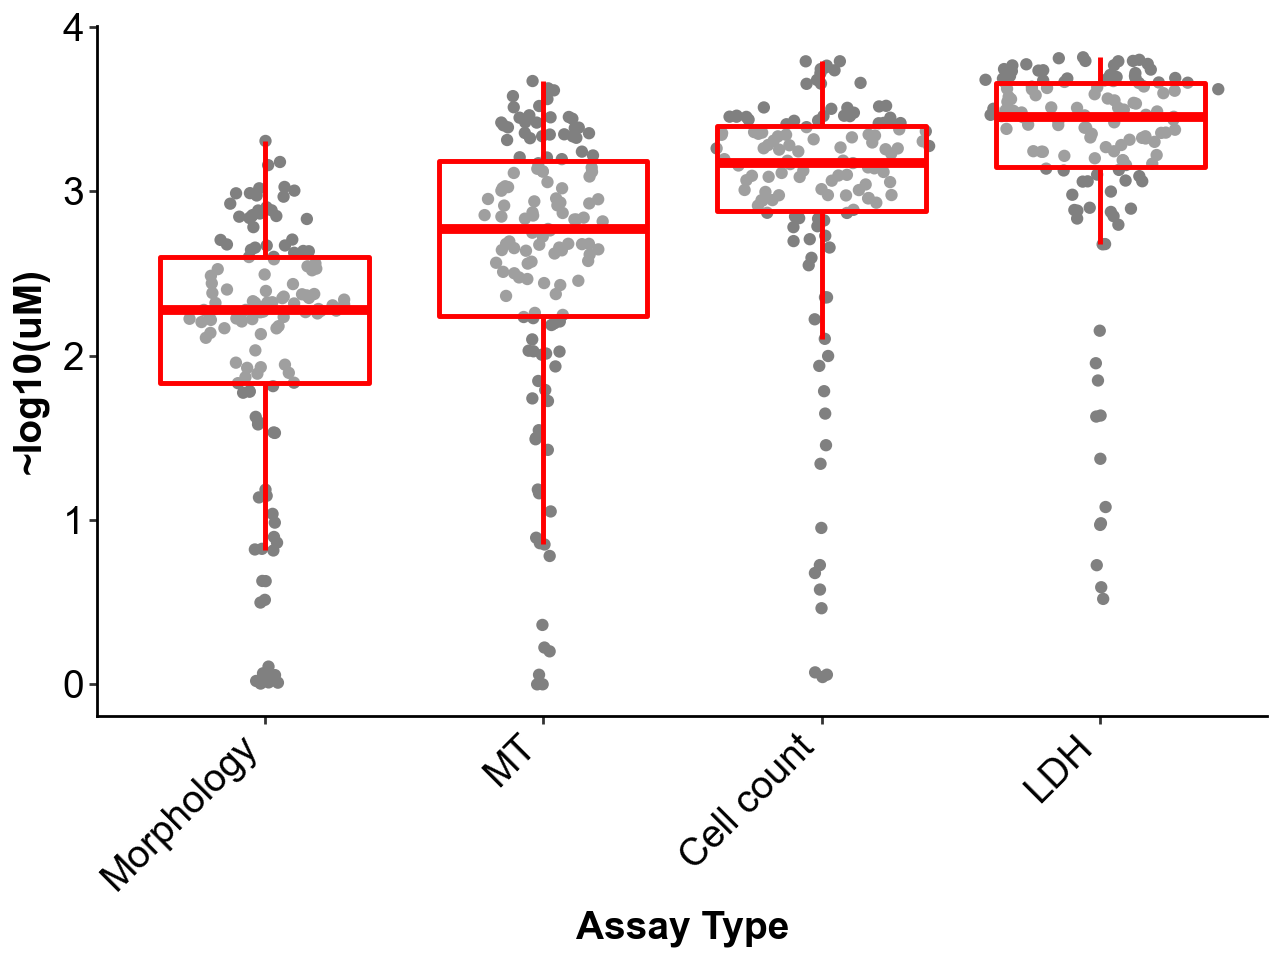

In [30]:
from plotnine import ggplot, aes, theme_classic, geom_boxplot, geom_sina, labs, theme, element_text, scale_x_discrete

plot = (
    ggplot(all_pods_long, aes(x='POD_Type', y='POD_Value')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1, outlier_alpha=0)
    + labs(x='Assay Type', y='~log10(uM)') 
    + theme_classic()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1, color='black', size=14, family='Arial'),
        axis_text_y=element_text(color='black', size=14, family='Arial'),
        axis_title_x=element_text(size=14, color='black', weight='bold', family='Arial'),
        axis_title_y=element_text(size=14, color='black', weight='bold', family='Arial'),
        )
    + scale_x_discrete(labels={
        "Metadata_morph_POD": "Morphology", 
        "Metadata_mtt_POD": "MT", 
        "Metadata_cc_POD": "Cell count",
        "Metadata_ldh_POD": "LDH"
    })
)
plot.show()

In [13]:
# Do paired t-tests between all combinations
pod_columns = ["Metadata_morph_POD", "Metadata_mtt_POD", "Metadata_cc_POD", "Metadata_ldh_POD"]
results = []

for i in range(len(pod_columns)):
    for j in range(i + 1, len(pod_columns)):
        col1 = pod_columns[i]
        col2 = pod_columns[j]
        
        paired_df = all_pods.filter(pl.col(col1).is_not_null() & pl.col(col2).is_not_null())
        
        values1 = paired_df[col1].to_numpy()
        values2 = paired_df[col2].to_numpy()
        
        t_stat, p_value = ttest_rel(values1, values2)
        mean_difference = (values1 - values2).mean()
        corr, corr_p_value = pearsonr(values1, values2)
        n_complete_obs = len(values1)

        results.append((col1, col2, n_complete_obs, t_stat, p_value, mean_difference, corr, corr_p_value))

results_df = pl.DataFrame(
    results, 
    schema=["var1", "var2", "n_complete_obs", "t_stat", "p_val", "mean_diff", "corr", "corr_pval"]
)
results_df = results_df.with_columns(
    (10 ** pl.col("mean_diff").abs()).alias("Fold_increase")
)
results_df

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/functools.py:888: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.


var1,var2,n_complete_obs,t_stat,p_val,mean_diff,corr,corr_pval,Fold_increase
str,str,i64,f64,f64,f64,f64,f64,f64
"""Metadata_morph_POD""","""Metadata_mtt_POD""",387,-11.669513,3.7115e-27,-0.385664,0.645137,6.3568e-47,2.430324
"""Metadata_morph_POD""","""Metadata_cc_POD""",218,-25.183524,2.4737e-66,-0.909336,0.747596,2.9441e-40,8.115884
"""Metadata_morph_POD""","""Metadata_ldh_POD""",143,-22.373321,2.1318e-48,-1.174513,0.659475,3.3724e-19,14.945598
"""Metadata_mtt_POD""","""Metadata_cc_POD""",213,-10.433038,7.8156e-21,-0.373064,0.770795,3.4384e-43,2.360828
"""Metadata_mtt_POD""","""Metadata_ldh_POD""",138,-12.891009,2.1373e-25,-0.640082,0.721123,1.9803e-23,4.36598
"""Metadata_cc_POD""","""Metadata_ldh_POD""",132,-8.865355,4.7981e-15,-0.275312,0.890912,2.1509e-46,1.885003


## Compare morphology PODs across representations

In [14]:
cellprofiler_dir = f"{output_dir}/cellprofiler/mad_featselect/curves"
cpcnn_dir = f"{output_dir}/cpcnn/mad_featselect/curves"
dino_dir = f"{output_dir}/dino/mad_featselect/curves"

data = pl.read_parquet(prof_path)

cellprofiler = pl.read_parquet(f"{cellprofiler_dir}/pods.parquet").select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_cellprofiler_POD"})
cpcnn = pl.read_parquet(f"{cpcnn_dir}/pods.parquet").select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_cpcnn_POD"})
dino = pl.read_parquet(f"{dino_dir}/pods.parquet").select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_dino_POD"})

data = data.join(cellprofiler, on="Metadata_Compound", how="left")
data = data.join(cpcnn, on="Metadata_Compound", how="left")
data = data.join(dino, on="Metadata_Compound", how="left")

all_pods = data.select([
    "Metadata_Compound",
    "Metadata_cellprofiler_POD",
    "Metadata_cpcnn_POD",
    "Metadata_dino_POD",
]).unique()

all_pods_long = all_pods.unpivot(
    index=["Metadata_Compound"],
    on=["Metadata_cellprofiler_POD", "Metadata_cpcnn_POD", "Metadata_dino_POD"],
    variable_name="POD_Type",
    value_name="POD_Value"
).drop_nulls().to_pandas()

all_pods_long['POD_Type'] = pd.Categorical(
    all_pods_long['POD_Type'],
    categories=["Metadata_cellprofiler_POD", "Metadata_dino_POD", "Metadata_cpcnn_POD"],
    ordered=True
)

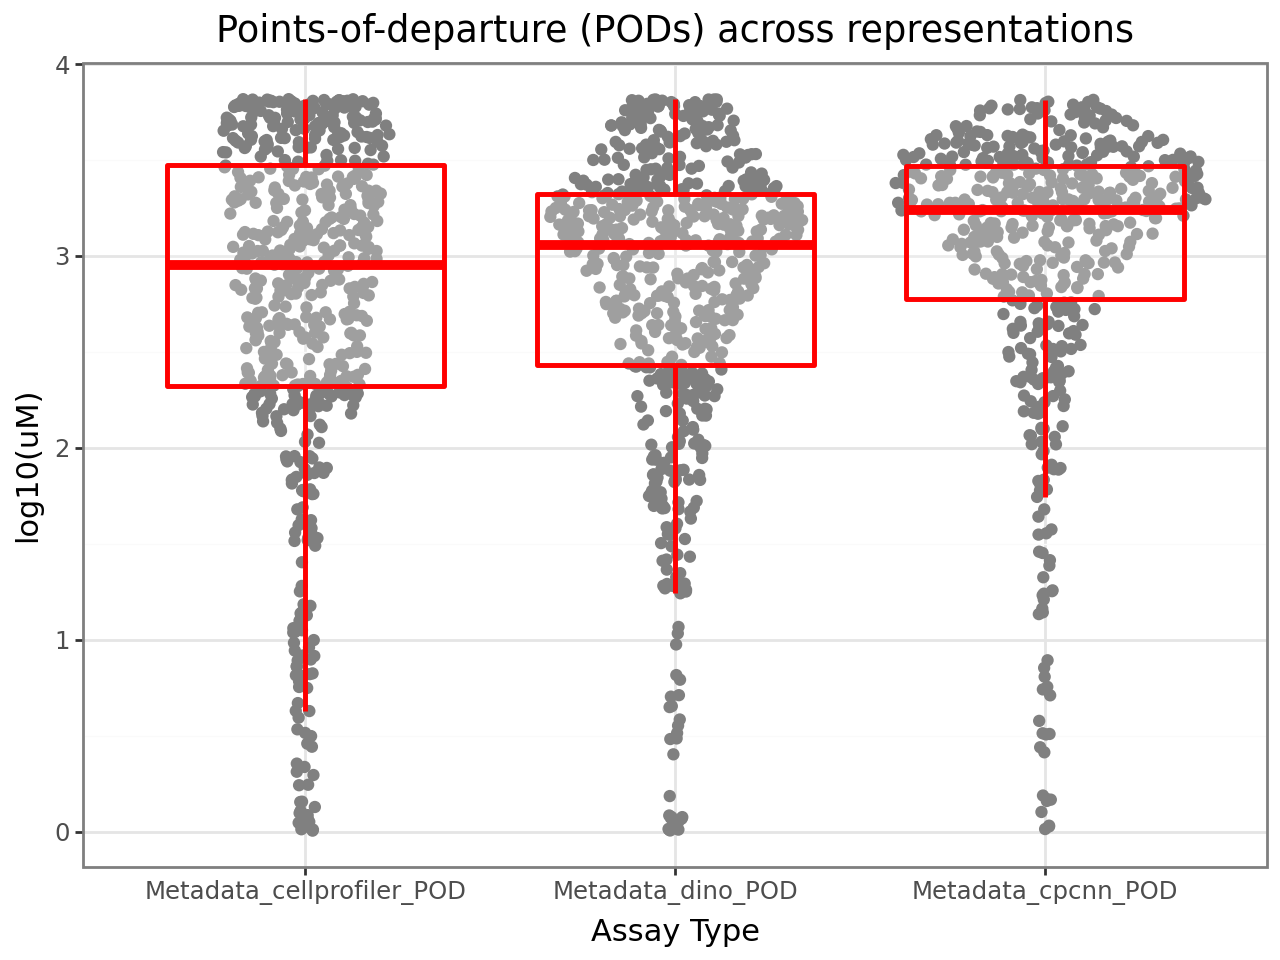

In [5]:
from plotnine import ggplot, aes, theme_bw, geom_boxplot, geom_sina, labs

plot = (
    ggplot(all_pods_long, aes(x='POD_Type', y='POD_Value')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1, outlier_alpha=0)
    + labs(title='Points-of-departure (PODs) across representations', x='Assay Type', y='log10(uM)') 
    + theme_bw()
)
plot.show()

In [15]:
pod_columns = ["Metadata_cellprofiler_POD", "Metadata_dino_POD", "Metadata_cpcnn_POD"]
results = []

for i in range(len(pod_columns)):
    for j in range(i + 1, len(pod_columns)):
        col1 = pod_columns[i]
        col2 = pod_columns[j]
        
        paired_df = all_pods.filter(pl.col(col1).is_not_null() & pl.col(col2).is_not_null())
        
        values1 = paired_df[col1].to_numpy()
        values2 = paired_df[col2].to_numpy()
        
        t_stat, p_value = ttest_rel(values1, values2)
        mean_difference = (values1 - values2).mean()
        corr, corr_p_value = pearsonr(values1, values2)
        n_complete_obs = len(values1)

        results.append((col1, col2, n_complete_obs, t_stat, p_value, mean_difference, corr, corr_p_value))

results_df = pl.DataFrame(
    results, 
    schema=["var1", "var2", "n_complete_obs", "t_stat", "p_val", "mean_diff", "corr", "corr_pval"]
)
results_df = results_df.with_columns(
    (10 ** pl.col("mean_diff").abs()).alias("Fold_increase")
)
results_df

/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/functools.py:888: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.


var1,var2,n_complete_obs,t_stat,p_val,mean_diff,corr,corr_pval,Fold_increase
str,str,i64,f64,f64,f64,f64,f64,f64
"""Metadata_cellprofiler_POD""","""Metadata_dino_POD""",527,-1.374629,0.169832,-0.038032,0.70152,2.8502e-79,1.091521
"""Metadata_cellprofiler_POD""","""Metadata_cpcnn_POD""",498,-9.483808,1.0109e-19,-0.248911,0.717907,4.7224e-80,1.773826
"""Metadata_dino_POD""","""Metadata_cpcnn_POD""",517,-12.408718,4.0016e-31,-0.20248,0.873222,6.7557e-163,1.593969


## Compare PODs across just global MD

In [16]:
data = pl.read_parquet(prof_path)

cellprofiler = pl.read_parquet(f"{cellprofiler_dir}/bmds.parquet").filter(
    (pl.col("gene.id") == "gmd") &
    (pl.col("all.pass") == True) &
    (pl.col("SDres") < 3*pl.col("SDctrl"))
).select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_cellprofiler_POD"})

cpcnn = pl.read_parquet(f"{cpcnn_dir}/bmds.parquet").filter(
    (pl.col("gene.id") == "gmd") &
    (pl.col("all.pass") == True) &
    (pl.col("SDres") < 3*pl.col("SDctrl"))
).select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_cpcnn_POD"})

dino = pl.read_parquet(f"{dino_dir}/bmds.parquet").filter(
    (pl.col("gene.id") == "gmd") &
    (pl.col("all.pass") == True) &
    (pl.col("SDres") < 3*pl.col("SDctrl"))
).select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_dino_POD"})


In [17]:

data = data.join(cellprofiler, on="Metadata_Compound", how="left")
data = data.join(cpcnn, on="Metadata_Compound", how="left")
data = data.join(dino, on="Metadata_Compound", how="left")

all_pods = data.select([
    "Metadata_Compound",
    "Metadata_cellprofiler_POD",
    "Metadata_cpcnn_POD",
    "Metadata_dino_POD",
]).unique()

all_pods_long = all_pods.unpivot(
    index=["Metadata_Compound"],
    on=["Metadata_cellprofiler_POD", "Metadata_cpcnn_POD", "Metadata_dino_POD"],
    variable_name="POD_Type",
    value_name="POD_Value"
).drop_nulls().to_pandas()

all_pods_long['POD_Type'] = pd.Categorical(
    all_pods_long['POD_Type'],
    categories=["Metadata_cellprofiler_POD", "Metadata_dino_POD", "Metadata_cpcnn_POD"],
    ordered=True
)

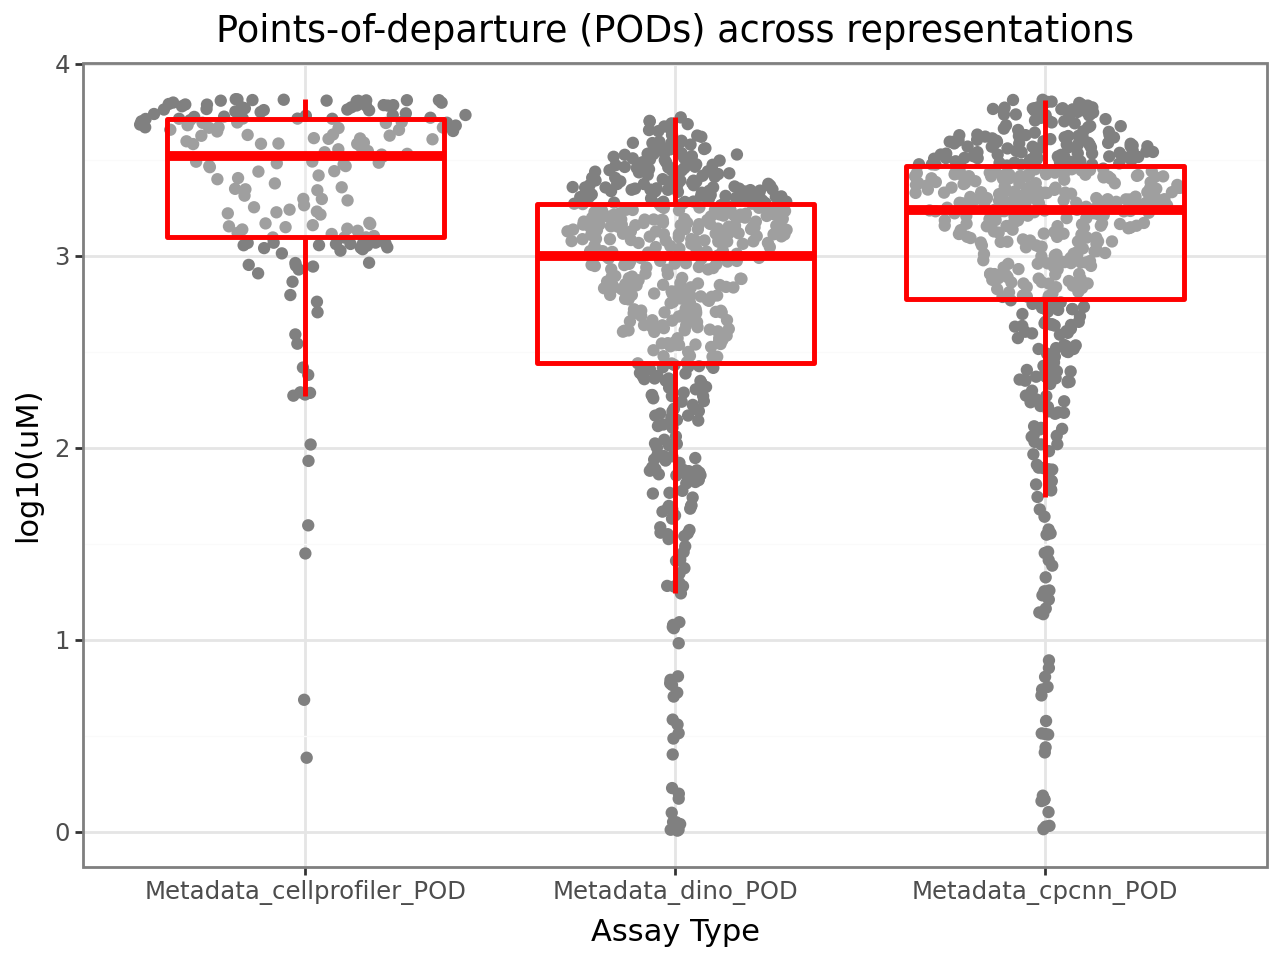

In [18]:
from plotnine import ggplot, aes, theme_bw, geom_boxplot, geom_sina, labs

plot = (
    ggplot(all_pods_long, aes(x='POD_Type', y='POD_Value')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1, outlier_alpha=0)
    + labs(title='Points-of-departure (PODs) across representations', x='Assay Type', y='log10(uM)') 
    + theme_bw()
)
plot.show()

## Compare PODs lowest categorical MD

In [19]:
data = pl.read_parquet(prof_path)

cellprofiler = pl.read_parquet(f"{cellprofiler_dir}/bmds.parquet").filter(
    (pl.col("gene.id") != "gmd") &
    (pl.col("all.pass") == True) &
    (pl.col("SDres") < 3*pl.col("SDctrl"))
).group_by("Metadata_Compound").agg(
    pl.col("bmd").min().alias("bmd")
).select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_cellprofiler_cmd_POD"})

dino = pl.read_parquet(f"{dino_dir}/bmds.parquet").filter(
    (pl.col("gene.id") != "gmd") &
    (pl.col("all.pass") == True) &
    (pl.col("SDres") < 3*pl.col("SDctrl"))
).group_by("Metadata_Compound").agg(
    pl.col("bmd").min().alias("bmd")
).select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_dino_cmd_POD"})

data = data.join(cellprofiler, on="Metadata_Compound", how="left")
data = data.join(dino, on="Metadata_Compound", how="left")

all_cmd_pods = data.select([
    "Metadata_Compound",
    "Metadata_cellprofiler_cmd_POD",
    "Metadata_dino_cmd_POD",
]).unique()

all_cmd_pods_long = all_cmd_pods.unpivot(
    index=["Metadata_Compound"],
    on=["Metadata_cellprofiler_cmd_POD", "Metadata_dino_cmd_POD"],
    variable_name="POD_Type",
    value_name="POD_Value"
).drop_nulls().to_pandas()

all_cmd_pods_long['POD_Type'] = pd.Categorical(
    all_cmd_pods_long['POD_Type'],
    categories=["Metadata_cellprofiler_cmd_POD", "Metadata_dino_cmd_POD"],
    ordered=True
)

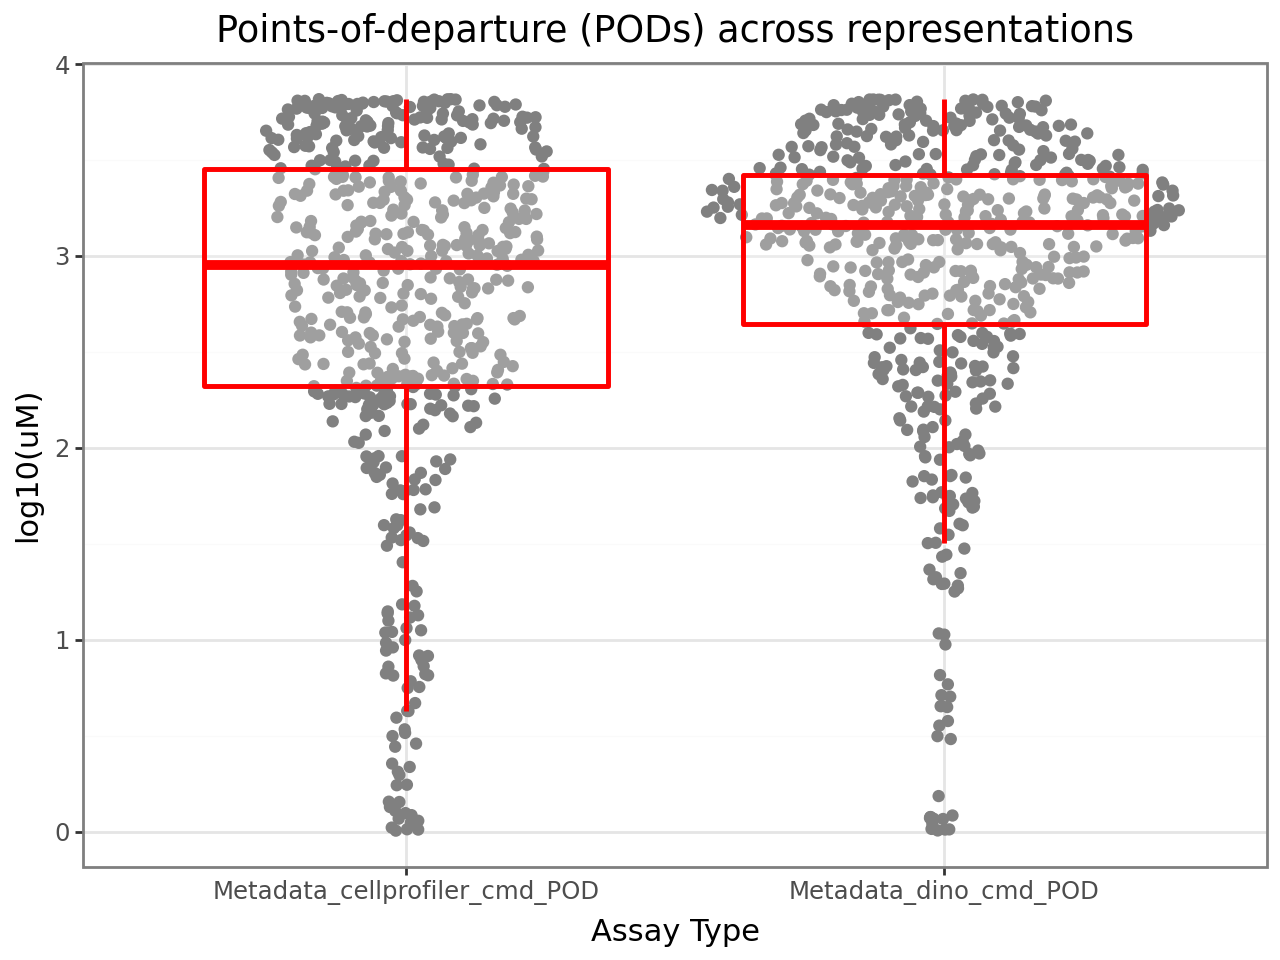

In [20]:
from plotnine import ggplot, aes, theme_bw, geom_boxplot, geom_sina, labs

plot = (
    ggplot(all_cmd_pods_long, aes(x='POD_Type', y='POD_Value')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1, outlier_alpha=0)
    + labs(title='Points-of-departure (PODs) across representations', x='Assay Type', y='log10(uM)') 
    + theme_bw()
)
plot.show()

## Visualize all together

In [21]:
gmd_cmd_pods = pl.concat([
    pl.from_pandas(all_pods_long), pl.from_pandas(all_cmd_pods_long)
], how="vertical").to_pandas()

gmd_cmd_pods['POD_Type'] = pd.Categorical(
    gmd_cmd_pods['POD_Type'],
    categories=["Metadata_cellprofiler_POD", "Metadata_cellprofiler_cmd_POD", "Metadata_dino_POD", "Metadata_dino_cmd_POD", "Metadata_cpcnn_POD"],
    ordered=True
)

sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


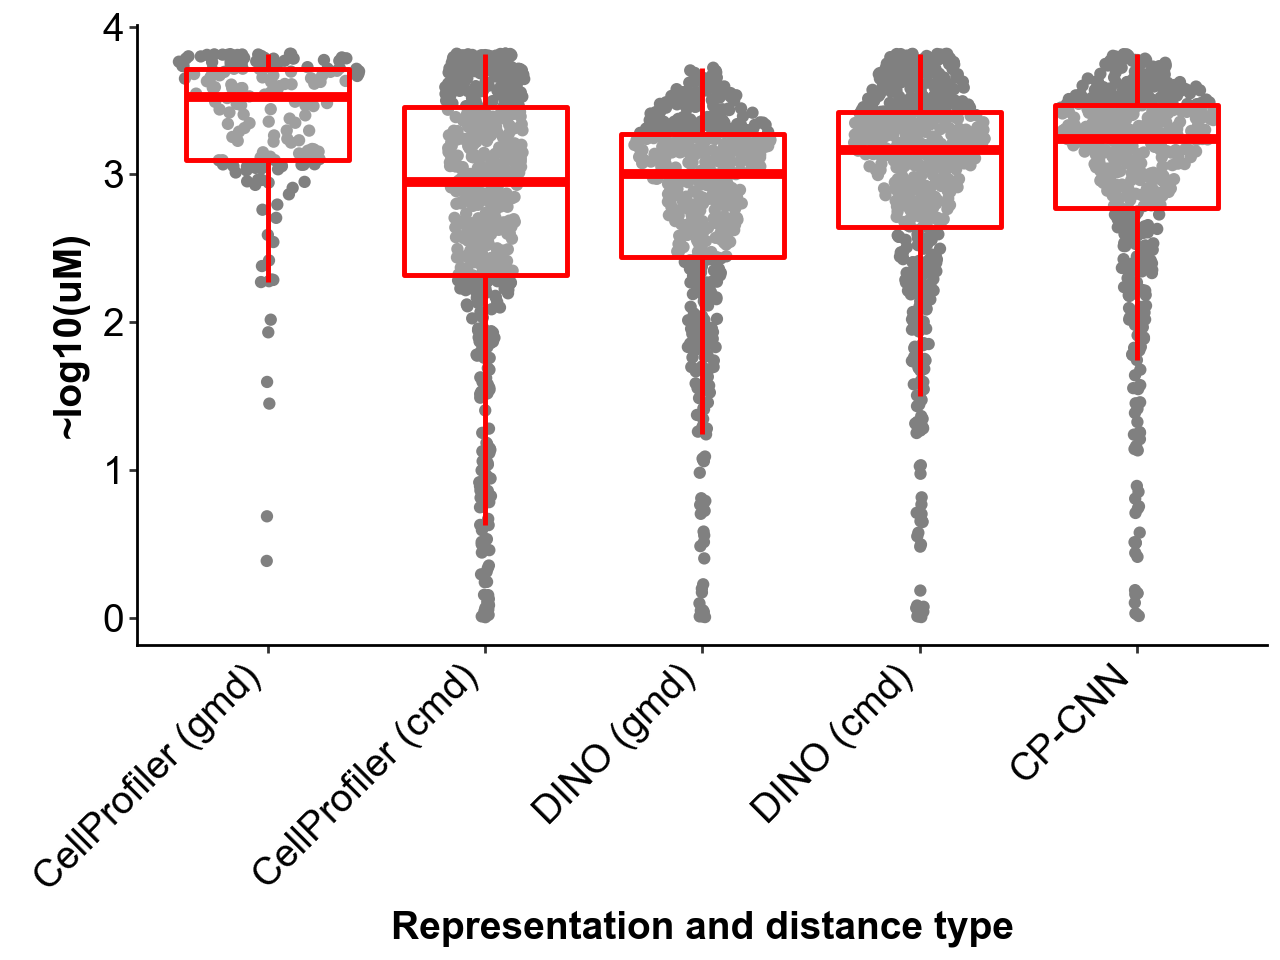

In [23]:
from plotnine import ggplot, aes, theme_classic, geom_boxplot, geom_sina, labs, theme, element_text, scale_x_discrete

plot = (
    ggplot(gmd_cmd_pods, aes(x='POD_Type', y='POD_Value')) 
    + geom_sina(color="grey") 
    + geom_boxplot(color="red", alpha=0.25, size=1, outlier_alpha=0)
    + labs(x='Representation and distance type', y='~log10(uM)') 
    + theme_classic()
    + theme(
        axis_text_x=element_text(angle=45, hjust=1, color='black', size=14, family='Arial'),
        axis_text_y=element_text(color='black', size=14, family='Arial'),
        axis_title_x=element_text(size=14, color='black', weight='bold', family='Arial'),
        axis_title_y=element_text(size=14, color='black', weight='bold', family='Arial'),
        )
    + scale_x_discrete(labels={
        "Metadata_cellprofiler_POD": "CellProfiler (gmd)", 
        "Metadata_cellprofiler_cmd_POD": "CellProfiler (cmd)", 
        "Metadata_dino_POD": "DINO (gmd)",
        "Metadata_dino_cmd_POD": "DINO (cmd)",
        "Metadata_cpcnn_POD": "CP-CNN"
    })
)
plot.show()